# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


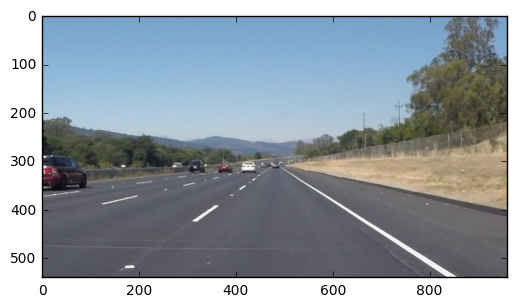

In [2]:
%matplotlib inline
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [1]:
####################################################################################################
####################################################################################################
# Name: Lane Finding
# Coder: Janson Fong
# Description:
#	Given a video with lane lines, this script outputs a video with lane lines highlighted in red.
# Change the input and output name in the main program to execute script on a different video in 
# your directory. 
#
####################################################################################################

####################################################################################################
# Libraries and Modules
####################################################################################################
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import numpy as np
import cv2
import math
####################################################################################################
# Constants
####################################################################################################

####################################################################################################
# Class Definitions
####################################################################################################

class Line:
	'''
	This class defines a line given two points. The slope and intercept of 
	a line can be calculated via the slope and intercept method
	'''
	def __init__(self, P1, P2):
		self.X1 = P1[0]
		self.Y1 = P1[1]
		self.X2 = P2[0]
		self.Y2 = P2[1]

	def slope(self):
		'''
		THis method returns the slope of a line defined by P1 and P2
		'''
		if (self.X2 - self.X1 != 0):
			self.m = (self.Y2 - self.Y1)/(self.X2 - self.X1)
		else:
			self.m = null

		return self.m

	def intercept(self):
		'''
		This method returns the intercept of a line defined by P1 and P2
		'''
		self.b = self.Y2 - self.m*self.X2

		return self.b

class FindLane:
	'''
	This class determines left and right lane given a set of hough lines
	sortByPoint and sortBySlope are two methods given to determine the 
	start and end points of a lane. A lane is represented as an instance 
	of the 'Line' class
	'''
	def __init__(self, lines):
		self.lines = lines 

	def sortByPoint(self):
		'''
		The sortByPoint method return the start and end points of lanes by 
		returning points with minimum and maximum y values respectively
		'''
		rightStartPoint = [0, 900]
		rightEndPoint = [0, 0]
		leftStartPoint = [0, 900]
		leftEndPoint = [0, 0]

		for eachLine in self.lines:
			for X1, Y1, X2, Y2 in eachLine:
				P1 = [X1, Y1]
				P2 = [X2, Y2]
				line = Line(P1, P2)
				slope  = line.slope()

				if (slope > 0):
					rightStartPoint = self.__findStartPoint(P1, P2, rightStartPoint)
					rightEndPoint = self.__findEndPoint(P1, P2, rightEndPoint)
				elif (slope < 0 and slope < -0.1):
					leftStartPoint = self.__findStartPoint(P1, P2, leftStartPoint)
					leftEndPoint = self.__findEndPoint(P1, P2, leftEndPoint)

		self.rightLane = Line(rightStartPoint, rightEndPoint)
		self.leftLane = Line(leftStartPoint, leftEndPoint)

	def sortBySlope(self):
		'''
		The sortBySlope method return the start and end points of lanes by
		averaging the slope and intercept of a set of lines. Using the averaged 
		slope and intercept, the start and end points of lanes are calculated 
		'''
		START_Y = 375
		END_Y = 900
		ZERO = 0.0
		rightLane = {}
		leftLane = {}

		for eachLine in self.lines:
			for X1, Y1, X2, Y2 in eachLine:
				P1 = [X1, Y1]
				P2 = [X2, Y2]
				line = Line(P1, P2)
				slope = line.slope()
				intercept = line.intercept()

				if (slope > 0):
					rightLane[slope] = intercept
				elif (slope < 0):
					leftLane[slope] = intercept

		# Ensuring lanes have enough points for filtering
		if (len(rightLane) > 1 and len(leftLane) > 1):
			# Removing extreme slopes
			rightLane.pop(max(rightLane))
			rightLane.pop(min(rightLane))
			leftLane.pop(max(leftLane))
			leftLane.pop(min(leftLane))

		# Checking for division by zero errors 
		if (len(rightLane) > 0 and len(leftLane) > 0):
			# Averaging slope
			rightSlope = self.__average(rightLane.keys())
			rightIntercept = self.__average(rightLane.values())
			leftSlope = self.__average(leftLane.keys())
			leftIntercept = self.__average(leftLane.values())

			# Calculating lane start, end point
			rightStartPoint = self.__calculateLaneCoor(rightSlope, rightIntercept, y = START_Y)
			rightEndPoint = self.__calculateLaneCoor(rightSlope, rightIntercept, y = END_Y)
			leftStartPoint = self.__calculateLaneCoor(leftSlope, leftIntercept, y = START_Y)
			leftEndPoint = self.__calculateLaneCoor(leftSlope, leftIntercept, y = END_Y)
		else:
			rightStartPoint = [1,1]
			rightEndPoint = [1,1]
			leftStartPoint = [1,1]
			leftEndPoint = [1,1]

		self.rightLane = Line(rightStartPoint, rightEndPoint)
		self.leftLane = Line(leftStartPoint, leftEndPoint)

	def __findStartPoint(self, P1, P2, startPoint):
		'''
		This private method returns the point with min y value
		'''
		if (P1[1] < P2[1]):
			if (P1[1] < startPoint[1]):
				return P1
			else:
				return startPoint
		else:
			if (P2[1] < startPoint[1]):
				return P2
			else:
				return startPoint

	def __findEndPoint(self, P1, P2, endPoint):
		'''
		This private method returns the point with max y value
		'''
		if (P1[1] > P2[1]):
			if (P1[1] > endPoint[1]):
				return P1
			else:
				return endPoint
		else:
			if (P2[1] > endPoint[1]):
				return P2
			else:
				return endPoint

	def __average(self, arrayList):
		'''
		This private method returns the average of an array
		'''
		return sum(arrayList)/len(arrayList)

	def __calculateLaneCoor(self, slope, intercept, x = None, y = None):
		'''
		This private method calculates the x or y value of a point given
		slope, intercept, and x or y
		'''
		if (x == None and y != None):
			x = int((y - intercept)/slope)
			return [x, y]
		elif (x != None and y == None):
			y = int(slope*x + intercept)
			return [x, y]

####################################################################################################
# Method Definitions
####################################################################################################
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
	"""
	This function draws `lines` with `color` and `thickness`.    
	Lines are drawn on the image inplace (mutates the image).
	"""
	lane = FindLane(lines)
	lane.sortBySlope()
	rightLane = lane.rightLane
	leftLane = lane.leftLane
	cv2.line(img, (rightLane.X1, rightLane.Y1), (rightLane.X2, rightLane.Y2), color, thickness)
	cv2.line(img, (leftLane.X1, leftLane.Y1), (leftLane.X2, leftLane.Y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def removeBackground(image):
	"""
	This method isolates a road in an image by removing the background 
	"""
	ySize = image.shape[0]
	xSize = image.shape[1]
	apex = [xSize/2, ySize/2]
	tolerance = 75
	leftBottom = [tolerance, ySize]
	rightBottom = [xSize - tolerance, ySize]
	region = np.array([[apex, leftBottom, rightBottom]], dtype=np.int32)
	filteredImg = region_of_interest(image, region)

	return filteredImg

def filterColor(image):
	"""
	This method isolates lane lines by blacking out regions below a RGB 
	threshold
	"""
	redThreshold = 200
	greenThreshold = 100
	blueThreshold = 0
	threshold = (image[:,:,0] < redThreshold) | \
	            (image[:,:,1] < greenThreshold) | \
	            (image[:,:,2] < blueThreshold)
	image[threshold] = [0,0,0]

	return image

def filterGray(image, threshold):
	"""
	This method isolates lane lines in a gray image by blacking out region
	below a threshold
	"""
	matchingField = image[:,:] < threshold
	image[matchingField] = 0

	return image

def process_image(image):
	'''
	This method returns the lanes of a image by first applying a gaussian blur,
	removing background details, filtering RGB colors, applying a grayscale,
	filtering a grayscale image, and applying canny transform. Red lane lines 
	are overlayed the original image.
	'''
	blurImage = gaussian_blur(image, 5)
	removeBackgroundImage = removeBackground(blurImage)
	RGBFilterImage = filterColor(removeBackgroundImage)
	grayImage = grayscale(RGBFilterImage)
	grayFilterImage = filterGray(grayImage, 190)
	cannyImage = canny(grayFilterImage, 80, 150)
	houghImage = hough_lines(cannyImage, 1, np.pi/180, 5, 15, 3)
	weightedImage = weighted_img(houghImage, image)

	return weightedImage

def laneFindVideo(title, inputVideo):
	'''
	This method returns a video with lane lines highlighted in red 
	'''
	video = title
	clip = VideoFileClip(inputVideo)
	videoClip = clip.fl_image(process_image)
	videoClip.write_videofile(video, audio=False)

	return video

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

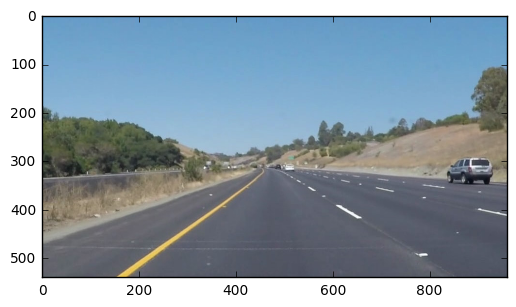

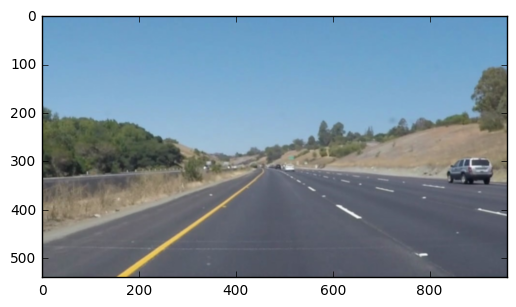

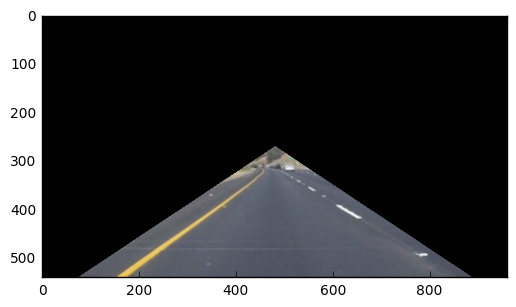

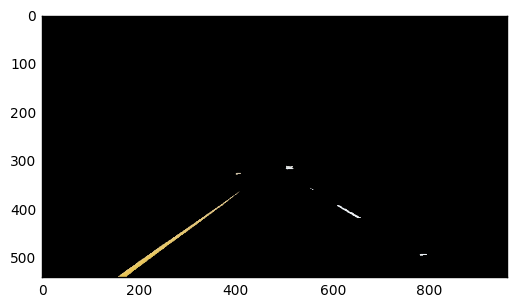

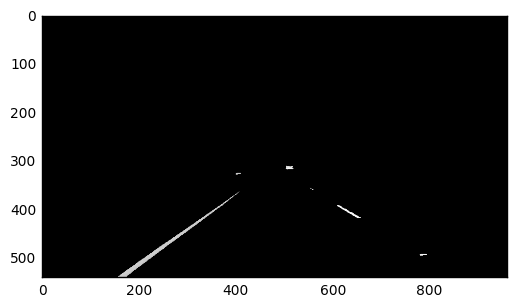

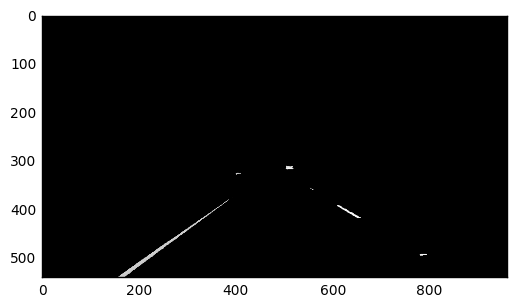

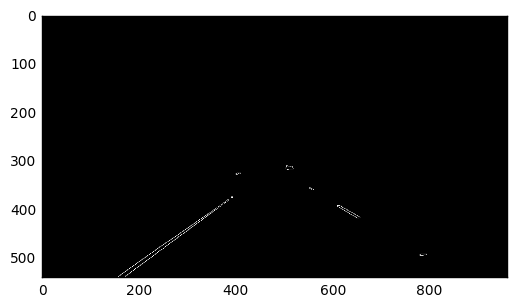

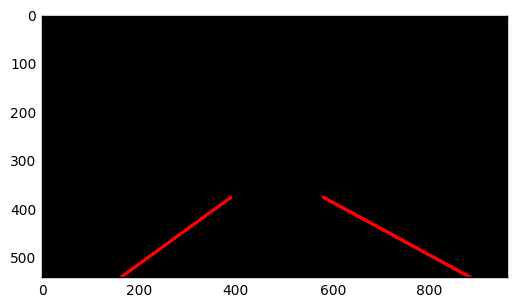

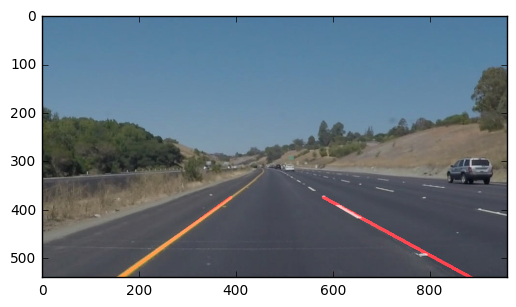

In [4]:
image = mpimg.imread('test_images/solidYellowCurve.jpg')

plt.imshow(image)

blurImage = gaussian_blur(image, 5)
plt.figure()
plt.imshow(blurImage, cmap='gray')

removeBackgroundImage = removeBackground(blurImage)
plt.figure()
plt.imshow(removeBackgroundImage, cmap='gray')

RGBFilterImage = filterColor(removeBackgroundImage)
plt.figure()
plt.imshow(RGBFilterImage)

grayImage = grayscale(RGBFilterImage)
plt.figure()
plt.imshow(grayImage, cmap='gray')

grayFilterImage = filterGray(grayImage, 190)
plt.figure()
plt.imshow(grayFilterImage, cmap='gray')

cannyImage = canny(grayFilterImage, 80, 150)
plt.figure()
plt.imshow(cannyImage, cmap='Greys_r')

houghImage = hough_lines(cannyImage, 1, np.pi/180, 5, 15, 3)
plt.figure()
plt.imshow(houghImage)

weightedImage = weighted_img(houghImage, image)
plt.figure()
plt.imshow(weightedImage)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def process_image(image):
    blurImage = gaussian_blur(image, 5)
    removeBackgroundImage = removeBackground(blurImage)
    RGBFilterImage = filterColor(removeBackgroundImage)
    grayImage = grayscale(RGBFilterImage)
    grayFilterImage = filterGray(grayImage, 190)
    cannyImage = canny(grayFilterImage, 80, 150)
    houghImage = hough_lines(cannyImage, 1, np.pi/180, 5, 15, 3)
    weightedImage = weighted_img(houghImage, image)
    
    return weightedImage

Let's try the one with the solid white lane on the right first ...

In [16]:
white_output = laneFindVideo('white.mp4', 'solidWhiteRight.mp4')

  self.nchannels))



[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 36.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 



Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [18]:
yellow_output = laneFindVideo('yellow.mp4', 'solidYellowLeft.mp4')

  self.nchannels))



[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:17<00:00, 39.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 



In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

The color filtration scheme used to process lane images is partially successful in determining lane lines. It fails when the background contains lane line colors. One way to overcome this is by filtering the slope of hough lines and removing the background. Removing lines with extreme slope values provide an additional layer of filtering not acomplished via color filtration. Will continue to improve script to make algorithm more robust. Problems to resolve include:
1. What to return when no lane lines are detected
2. How to make algorithm relevant when switching lanes.

Progress can be monitored via https://github.com/zcfang/ND013


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [23]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


 35%|███▍      | 87/251 [00:05<00:11, 14.81it/s]

NameError: name 'null' is not defined

 35%|███▍      | 87/251 [00:20<00:37,  4.35it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))